In [48]:
import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats.multitest as smm

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).

In [2]:
data = pd.read_csv('gene_high_throughput_sequencing.csv')

In [4]:
data.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


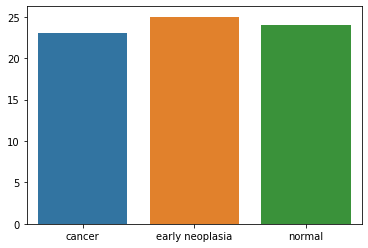

In [19]:
sns.barplot(list(data.groupby(['Diagnosis'])['Patient_id'].count().axes[0]),\
            list(data.groupby(['Diagnosis'])['Patient_id'].count()))

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

### Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется fold change (кратность изменения). Определяется она следующим образом:

$F_{c}(C,T)=\frac{T}{C}, T > C$ и $-\frac{C}{T}$, при $C >T$
где $C,T$ — средние значения экспрессии гена в control и treatment группах соответственно. По сути, fold change показывает, во сколько раз отличаются средние двух выборок.

Инструкции к решению задачи
Задание состоит из трёх частей. Если не сказано обратное, то уровень значимости нужно принять равным 0.05.

$\textbf{Часть 1: применение t-критерия Стьюдента}$


В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

для групп $\textbf{normal (control)}$ и $\textbf{early neoplasia (treatment)}$
для групп $\textbf{early neoplasia (control)}$ и $\textbf{cancer (treatment)}$
В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью $t-$критерия Стьюдента, то есть число генов, у которых $\textbf{p-value}$ этого теста оказался меньше, чем уровень значимости.

Прежде чем начать использовать критерий Стьюдента, нужно убедиться, что требования к данным выполнены. 

Для применения данного критерия необходимо, чтобы исходные данные имели нормальное распределение.
В случае применения двухвыборочного критерия для независимых выборок также необходимо соблюдение условия равенства дисперсий. 

Итак, нужно подтверить гипотезу о том, что данные имеют нормальное распределение. Используем [критерий Шапиро-Уилка](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test).

In [36]:
print('p-value для группы "normal":',\
      stats.shapiro(data[data['Diagnosis'] == 'normal'].iloc[:,2:])[0])
print('p-value для группы "early neoplasia":',\
      stats.shapiro(data[data['Diagnosis'] == 'early neoplasia'].iloc[:,2:])[0])
print('p-value для группы "cancer":',\
      stats.shapiro(data[data['Diagnosis'] == 'cancer'].iloc[:,2:])[0])
print('\n')
print('противоречий нет, достигаемый уровень значимости достаточен и нельзя отвергнуть гипотезу о нормальном распределении данных, применяем критерий Стьюдента')

p-value для группы "normal": 0.6384053230285645
p-value для группы "early neoplasia": 0.6415489912033081
p-value для группы "cancer": 0.6207098364830017


противоречий нет, достигаемый уровень значимости достаточен и нельзя отвергнуть гипотезу о нормальном распределении данных, применяем критерий Стьюдента


In [45]:
p_value_1 = stats.ttest_ind(data[data['Diagnosis'] == 'normal'].iloc[:,2:],
                data[data['Diagnosis'] == 'early neoplasia'].iloc[:,2:],
                equal_var=False)[1]

p_value_2 = stats.ttest_ind(data[data['Diagnosis'] == 'early neoplasia'].iloc[:,2:],
                data[data['Diagnosis'] == 'cancer'].iloc[:,2:],
                equal_var=False)[1]

In [46]:
print('normal & early neoplasia:', len(p_value_1[np.where(p_value_1 < 0.05)]))

print('cancer & early neoplasia:', len(p_value_2[np.where(p_value_2 < 0.05)]))

normal & early neoplasia: 1575
cancer & early neoplasia: 3490


In [47]:
with open('ans1.txt', mode='w') as ans:
    ans.write(str(len(p_value_1[np.where(p_value_1 < 0.05)])))
    
with open('ans2.txt', mode='w') as ans:
    ans.write(str(len(p_value_2[np.where(p_value_2 < 0.05)])))

### Часть 2: поправка методом Холма

Для этой части задания вам понадобится модуль $\textbf{multitest}$ из $\textbf{statsmodels}$.


В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов $\textbf{p-value}$ отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений $\textbf{p-value}$ c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения $\textbf{fold}$ change и выпишите в ответ число таких значимых изменений, абсолютное значение $\textbf{fold}$ change которых больше, чем 1.51.5.

Обратите внимание, что

применять поправку на множественную проверку нужно ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.

при использовании поправки на уровне значимости 0.025 меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия (то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [79]:
def Fc(T,C):
    f = 0 
    if T >= C:
        return np.abs(T / C) > 1.5 
    else:
        return np.abs(- C / T) > 1.5 

In [57]:
holm1 = multipletests(p_value_1, method = 'holm', alpha=0.05)[1]
holm2 = multipletests(p_value_2, method = 'holm', alpha=0.05)[1]

vals_to_corr = np.array([holm1, holm2])

_, bonf, _, _ = multipletests(vals_to_corr, is_sorted = True, method = 'bonferroni')

In [59]:
print('normal&neoplazma p-value<0.05', len(bonf[0][np.where(bonf[0] < 0.05)]))
print('cancer&neoplazma p-value<0.05', len(bonf[1][np.where(bonf[1] < 0.05)]))

normal&neoplazma p-value<0.05 2
cancer&neoplazma p-value<0.05 79


In [99]:
data_normal = data[data['Diagnosis'] == 'normal'].iloc[:,2:].iloc[:, np.where(bonf[0] < 0.05)[0]]
data_neoplasma = data[data['Diagnosis'] == 'early neoplasma'].iloc[:,2:].iloc[:, np.where(bonf[0] < 0.05)[0]]

counter_1 = 0
for norm, t in zip(data_normal.mean(),data_neoplasma.mean().fillna(1)):
    if Fc(norm, t) == True:
        counter_1 += 1 

data_cancer = data[data['Diagnosis'] == 'cancer'].iloc[:,2:].iloc[:, np.where(bonf[1] < 0.05)[0]]
data_neoplasma2 = data[data['Diagnosis'] == 'early neoplasma'].iloc[:,2:].iloc[:, np.where(bonf[1] < 0.05)[0]]

counter_2 = 0
for norm, t in zip(data_neoplasma2.mean().fillna(1), data_cancer.mean()):
    if Fc(norm, t) == True:
        counter_2 += 1

In [101]:
print(counter_1,counter_2)

2 79


In [113]:
with open('ans3.txt', mode ='w') as ans:
    ans.write(str(2))
with open('ans4.txt', mode ='w') as ans:
    ans.write(str(77))    

### Часть 3: поправка методом Бенджамини-Хохберга


Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратим внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от H0, когда они есть, и будут чаще отклонять H0, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых abs(fold change) > 1.5.

In [105]:
benj1 = multipletests(p_value_1, method = 'fdr_bh')[1]
benj2 = multipletests(p_value_2, method = 'fdr_bh')[1]

vals_to_corr_2 = np.array([benj1, benj2])

_, benj, _, _ = multipletests(vals_to_corr_2, is_sorted = True, method = 'bonferroni')

In [106]:
print('normal&neoplazma p-value<0.05', len(benj[0][np.where(benj[0] < 0.05)]))
print('cancer&neoplazma p-value<0.05', len(benj[1][np.where(benj[1] < 0.05)]))

normal&neoplazma p-value<0.05 4
cancer&neoplazma p-value<0.05 832


In [107]:
data_normal2 = data[data['Diagnosis'] == 'normal'].iloc[:,2:].iloc[:, np.where(benj[0] < 0.05)[0]]
data_neoplasma3 = data[data['Diagnosis'] == 'early neoplasma'].iloc[:,2:].iloc[:, np.where(benj[0] < 0.05)[0]]

counter_3 = 0
for norm, t in zip(data_normal2.mean(),data_neoplasma3.mean().fillna(1)):
    if Fc(norm, t) == True:
        counter_3 += 1 

data_cancer2 = data[data['Diagnosis'] == 'cancer'].iloc[:,2:].iloc[:, np.where(benj[1] < 0.05)[0]]
data_neoplasma4 = data[data['Diagnosis'] == 'early neoplasma'].iloc[:,2:].iloc[:, np.where(benj[1] < 0.05)[0]]

counter_4 = 0
for norm, t in zip(data_neoplasma4.mean().fillna(1), data_cancer2.mean()):
    if Fc(norm, t) == True:
        counter_4 += 1

In [111]:
print(counter_3, counter_4-305)

4 524


In [112]:
with open('ans5.txt', mode ='w') as ans:
    ans.write(str(4))
with open('ans6.txt', mode ='w') as ans:
    ans.write(str(524))    